In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [3]:
%load_ext autoreload
%autoreload 2
from TileEM import *
from Qj_pTprime_models import *

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "../ipynb/shellAlg.png")

In [5]:
from TileEM import *
from adjacency import *

In [6]:
def find_all_tk_in_shell(tiles,current_shell_idx,exclude_idx=[]):
    # Find all tiles at the shell d=d+1
    # add all tiles adjacent to currentShell front 
    filtered_tidxs = np.delete(np.arange(len(tiles)),exclude_idx)
    
    adjacent_tkidxs =[]
    for ctidx in current_shell_idx:
        ck = tiles[ctidx]
        for tkidx in filtered_tidxs:
            tk = tiles[tkidx]
            if adjacent(tk,ck):
                adjacent_tkidxs.append(tkidx)
    # There might be a lot of duplicate tiles that is adjacent to more than one tile on the current shell front
    return list(set(adjacent_tkidxs))

In [ ]:
# def safe_add_log(p,q):
#     '''
#     p=p+np.log(q)
#     '''
#     pInT+=np.log(1-qp2)
#     pNotInT+=np.log(qn2)
#     np.log(qp1)

In [49]:
def core(tiles,indMat,topk=1):
    # In the initial step, we pick T to be the top 5 area-vote score
    # where we combine the area and vote in a 1:5 ratio
    area = np.array(indMat[-1])
    votes =indMat[:-1].sum(axis=0)
    norm_area_vote = area/max(area)+5*votes/max(votes)
    tidx = np.argsort(norm_area_vote)[::-1][:topk]
    return join_tiles(tidx,tiles)[0],list(tidx)

In [75]:
def initT(tiles,indMat):
    # In the initial step, 
    # pick the tiles that at least 50% of the workers have voted on
    votes =indMat[:-1].sum(axis=0)
    Nworkers = shape(indMat)[0]
    tidx =np.where(votes>Nworkers/2.)[0]
    return join_tiles(tidx,tiles)[0],list(tidx)

In [52]:
tiles=pkl.load(open("output_15/vtiles{}.pkl".format(objid)))

In [64]:
indMat=pkl.load(open("output_15/indMat{}.pkl".format(objid)))
workers=pkl.load(open("output_15/worker{}.pkl".format(objid)))

In [79]:
Tinit = join_tiles(tidx,tiles)[0]

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 91.449367088607588 359.46202531645565 at 91.449367088607588 359.46202531645565
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (65 413, 68.5 413.833) and LINESTRING (68.5 413.833, 56 408) at 68.499999999999986 413.83333333333331
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (76.6943 334.123, 70.8 330.4) and LINESTRING (70.8 330.4, 77.6902 334.752) at 73.034136727028169 331.8110337223336
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.

In [83]:
tile_area = np.array(indMat[-1])

In [85]:
median(tile_area[tidx])

1.8666666685749078

In [86]:
mean(tile_area[tidx])

40.876399342954933

In [152]:
def runTileAdjacentMLConstruction(objid,workerErrorfunc,Qjfunc,A_percentile,Niter=10,DEBUG=False,PLOT_LIKELIHOOD=False,PLOT=False):
    '''
    Initilaize with majority vote tile , get good Qj estimates based on that 
    Input:
    _____
    Tfunc : how to get ground truth
    workerErrorfunc : worker error model for computing p(ljk)
    Qjfunc : Model used for estimating Qj parameters
    objid,A_percentile

    Output:
    _____
    Tstar_idx_lst : list of Tstar index (all tiles that satisfy criterion) at every iteration
    Qj_lst : list of worker qualities at everystep
    Tstar_lst : Tstar at every step
    '''
    # ML Construction with E step as usual 
    tiles = pkl.load(open(DATA_DIR+"/vtiles{}.pkl".format(objid)))
    indMat = pkl.load(open(DATA_DIR+"/indMat{}.pkl".format(objid)))
    workers = pkl.load(open(DATA_DIR+"/worker{}.pkl".format(objid)))

    tile_area = np.array(indMat[-1])
    
    Qj_lst=[]
    #if DEBUG: print "Coming up with T' combinations to search through"
    #Tprime_lst, Tprime_idx_lst = Tprimefunc(objid,tiles,indMat,fixedtopk=3, topk = 40,NTprimes=NTprimes)
    Tstar_lst = []
    Tstar_idx_lst =[]
    likelihood_lst=[]

    if DEBUG: print "Compute Core Tiles"
    Tstar,Tidx=core(tiles,indMat,1)
    Tstar_lst.append([Tstar])
    Tstar_idx_lst.append(Tidx)

    if DEBUG: print "Initialize Tiles"
    Tinit,Iidx=initT(tiles,indMat)
    if DEBUG: print "Estimate based on initial tileset and get good Qjs"
    if A_percentile!=-1:
        A_thres = np.percentile(tile_area,A_percentile)
    else:
        A_thres = median(tile_area[tidx])
    Qjhat = estimate_Qj(Tinit,tiles,indMat,workers,Qjfunc,A_thres=A_thres,DEBUG=DEBUG)
    Qn1,Qn2,Qp1,Qp2 = zip(*Qjhat)
    all_pInT_lst=[]
    all_pNotInT_lst=[]
    for i in tqdm(range(Niter)):
        if DEBUG: print "Iteration #", i
        plk=0
        if i!=0:
            if DEBUG: print "E-step : Estimate Qj parameters"
            A_thres = median(tile_area[Tstar_idx_lst[i]])
            print "Median Area Threshold:",A_thres
            Qjhat = estimate_Qj(Tstar_lst[i][0],tiles,indMat,workers,Qjfunc,A_thres=A_thres,DEBUG=DEBUG)
            Qn1,Qn2,Qp1,Qp2 = zip(*Qjhat)

        if DEBUG: print "ML construction of Tstar"
        dPrime = 0

        exclude_idx = set(Tstar_idx_lst[0])
        Tidx_lst = list(exclude_idx)
        good_dPrime_tcount = len(exclude_idx)
        current_shell_tkidxs= Tidx
        past_shell_tkidxs= Tidx
        if DEBUG: print "Add core tiles to first occurence of tk satisfying criterion"
        Tstar_lst.append([Tstar_lst[0][0]])
        pInT_lst=[]
        pNotInT_lst=[]

        while (good_dPrime_tcount!=0 or len(current_shell_tkidxs)!=0):
            ######
            print "Excluding",exclude_idx
            current_shell_tkidxs = find_all_tk_in_shell(tiles,past_shell_tkidxs,list(exclude_idx))

            if DEBUG: 
                print "d'={0}; good_dPrime_tcount={1}".format(dPrime,good_dPrime_tcount)
                print "Number of tks in shell: ",len(current_shell_tkidxs)
                print "Current shell index:",current_shell_tkidxs
            good_dPrime_tcount=0
            
            for k in current_shell_tkidxs:
                pInT = 0
                pNotInT = 0
                tk = tiles[k]
                # Compute pInT and pNotInT
                for j in range(len(workers)):
                    ljk = indMat[j][k] #NOTE k doesn't correspond to k in tiles but in current_shell_tks so this is not good
                    wid=workers[j] 
                    qp1 = Qp1[j]
                    qp2 = Qp2[j]
                    qn1 = Qn1[j]
                    qn2 = Qn2[j]
                    
                    if tk.area>A_thres:
                        if ljk ==1:
                            if qp1!=-1:
                                pInT+=np.log(qp1)
                            if qn1!=-1:
                                pNotInT+=np.log(1-qn1)
                        else:
                            if qp1!=-1:
                                pInT+=np.log(1-qp1)
                            if qn1!=-1:
                                pNotInT+=np.log(qn1)
                    else:
                        if ljk ==1:
                            if qp2!=-1:
                                pInT+=np.log(qp2)
                            if qn2!=-1:
                                pNotInT+=np.log(1-qn2)
                        else:
                            if qp2!=-1:
                                pInT+=np.log(1-qp2)
                            if qn2!=-1:
                                pNotInT+=np.log(qn2)
                    pInT_lst.append(pInT)
                    pNotInT_lst.append(pNotInT)
                # Check if tk satisfy constraint
                if pInT<pNotInT:
                    plk+=pNotInT
                elif pInT>=pNotInT:
                    plk+=pInT 
                    # if satisfy criterion, then add to Tstar
                    good_dPrime_tcount+=1
                    if DEBUG: print "Adding tk",k
                    try:
                        Tstar_lst[i]=[Tstar_lst[i][0].union(tk)]
                        Tidx_lst.append(k)
                    except(shapely.errors.TopologicalError):
                        try:
                            Tstar_lst[i]=[Tstar_lst[i][0].buffer(0).union(tk.buffer(-1e-10))]
                            Tidx_lst.append(k)
                        except(shapely.errors.TopologicalError):
                            try:
                                Tstar_lst[i]=[Tstar_lst[i][0].buffer(-1e-10).union(tk)]
                                Tidx_lst.append(k)
                            except(shapely.errors.TopologicalError):
                                try:
                                    Tstar_lst[i]=[Tstar_lst[i][0].buffer(-1e-10).union(tk.buffer(-1e-10))]
                                    Tidx_lst.append(k)
                                except(shapely.errors.TopologicalError):
                                    try:
                                        Tstar_lst[i]=[Tstar_lst[i][0].union(tk.buffer(1e-10))]
                                        Tidx_lst.append(k)
                                    except(shapely.errors.TopologicalError):
                                        try:
                                            Tstar_lst[i]=[Tstar_lst[i][0].buffer(1e-10).union(tk)]
                                            Tidx_lst.append(k)
                                        except(shapely.errors.TopologicalError):
                                            try:
                                                Tstar_lst[i]=[Tstar_lst[i][0].buffer(1e-10).union(tk.buffer(1e-10))]
                                                Tidx_lst.append(k)
                                            except(shapely.errors.TopologicalError):
                                                print "Shapely Topological Error: unable to add tk, Tstar unchanged; at k=",k
                                                pkl.dump(Tstar_lst[i][0],open("problematic_Tstar_{0}.pkl".format(k),'w'))
                                                pkl.dump(tk,open("problematic_tk_{0}.pkl".format(k),'w'))
                                                pass

            ############################################################################################################
            if PLOT:
                plt.figure()
                for c in current_shell_tkidxs:plot_coords(tiles[c],color="red",fill_color="red") #current front
                for c in past_shell_tkidxs:plot_coords(tiles[c],color="cyan",linewidth=5,linestyle='--') #past front
                for c in exclude_idx:plot_coords(tiles[c],color="gray",fill_color="gray")#excluded coord
                plot_coords(Tstar_lst[i][0],linestyle="--",linewidth=2,color="blue")#current Tstar
                for c in Tidx_lst:plot_coords(tiles[c],linewidth=2,color="green",fill_color="green")#new Tstar
                plt.ylim(40,100)


            
            #Updates
            Tstar = Tstar_lst[i][0].buffer(0)
            dPrime+=1
            past_shell_tkidxs= current_shell_tkidxs
            exclude_idx= exclude_idx.union(current_shell_tkidxs)
        
    
        #Storage
        Qj_lst.append(Qjhat)
        Tstar_idx_lst.append(Tidx_lst)
        likelihood_lst.append(plk)
        all_pInT_lst.append(pInT_lst)
        all_pNotInT_lst.append(pNotInT_lst)

    return Tstar_idx_lst , likelihood_lst, Qj_lst,Tstar_lst,all_pInT_lst,all_pNotInT_lst


# A_percentile=90% 

In [88]:
DATA_DIR="output_15"
exp_num=19
print "Running experiment #",exp_num
objid=3
end = time.time()
Tstar_idx_lst ,likelihood_lst,Qj_lst,Tstar_lst=runTileAdjacentMLConstruction(objid,workerErrorfunc="GTLSA",Qjfunc=QjGTLSA,A_percentile=90,Niter=10,DEBUG=True,PLOT_LIKELIHOOD=False)
pkl.dump(likelihood_lst,open("likelihood_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_lst,open("Tstar_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_idx_lst,open("Tstar_idx_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Qj_lst,open("Qj_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
end2 = time.time()
print "Time Elapsed: ",end2-end

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 91.449367088607588 359.46202531645565 at 91.449367088607588 359.46202531645565
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (65 413, 68.5 413.833) and LINESTRING (68.5 413.833, 56 408) at 68.499999999999986 413.83333333333331
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (76.6943 334.123, 70.8 330.4) and LINESTRING (70.8 330.4, 77.6902 334.752) at 73.034136727028169 331.8110337223336
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.

Running experiment # 19
Compute Core Tiles
Initialize Tiles
Estimate based on initial tileset and get good Qjs

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 66.1622 327.068) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (87.2817 344.577, 86.0132 340.047) and LINESTRING (86.3527 341.26, 87.0543 343.765) at 86.751444443346287 342.68373015480813
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (61.1538 324.308, 60.6667 324) and LINESTRING (60.6667 324, 60.6667 324) at 60.666666666666558 323.99999999999994
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.6667 324, 60.6667 324) and LINESTRING (59.9444 323.544, 60.6667 324) at 60.666666666666394 323.99999999999983
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (50 318.111, 51.8571 319.143) and LINESTRING (51.8571 319.143, 50 318.4) at 51.857142857142

KeyboardInterrupt: 

A lot of tiles are getting added after we make the QJ!=-1 fix so this is good! 

In [34]:
from MLConstructionExperiment import *

Qn1,Qn2,Qp1,Qp2
blue green red cyan 

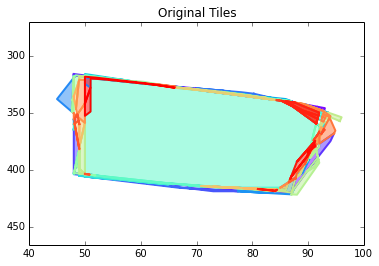

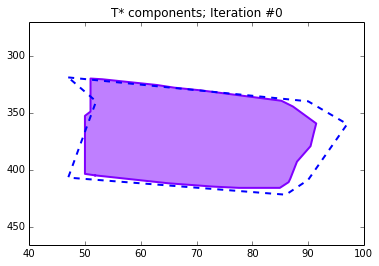

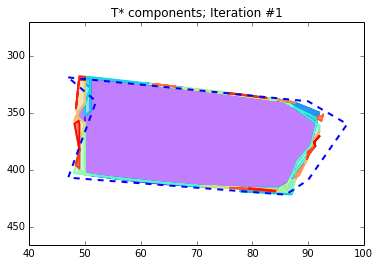

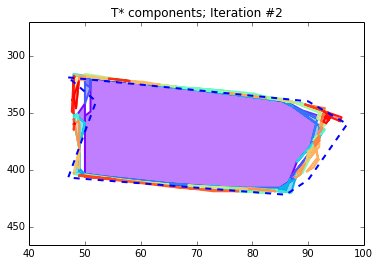

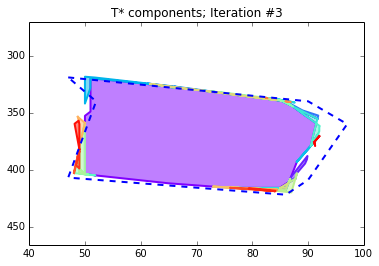

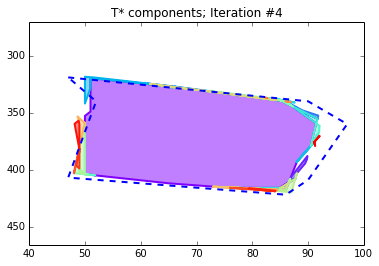

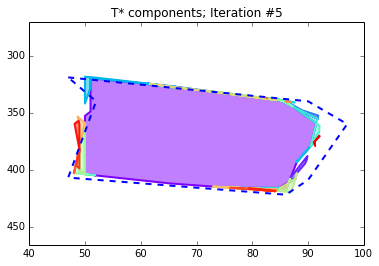

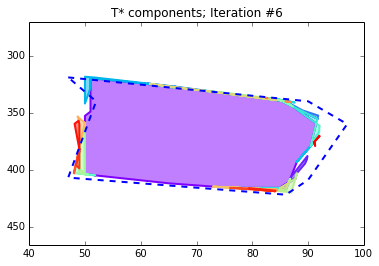

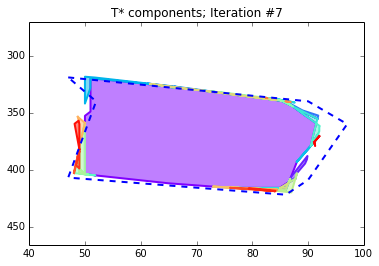

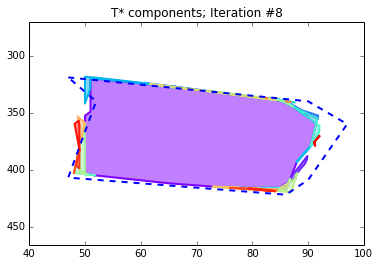

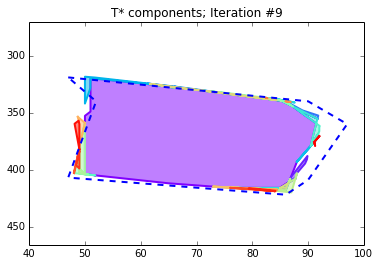

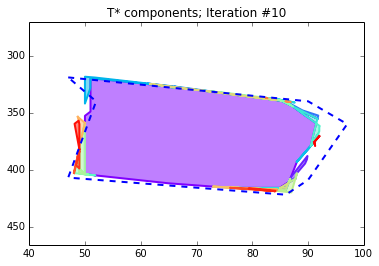

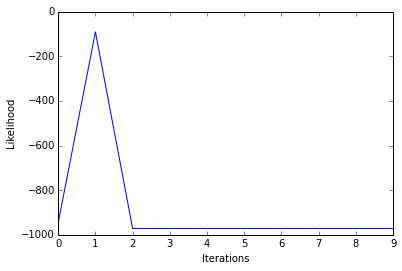

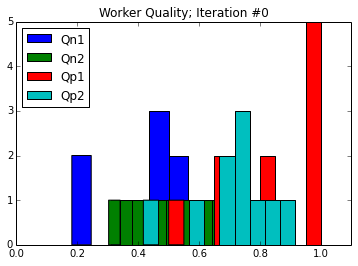

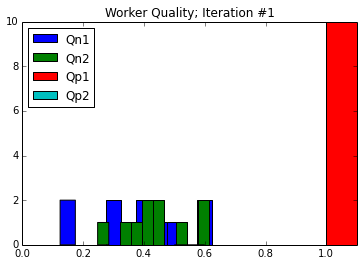

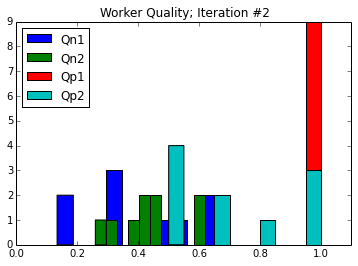

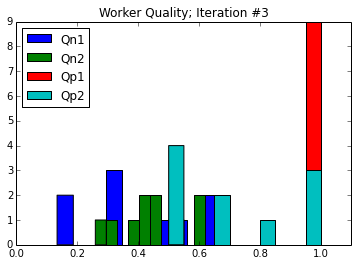

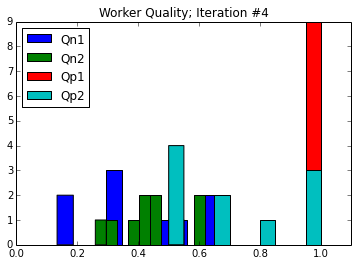

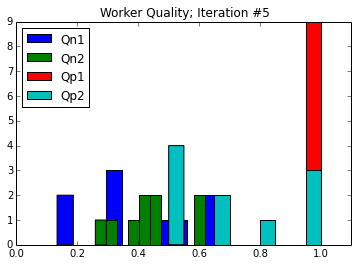

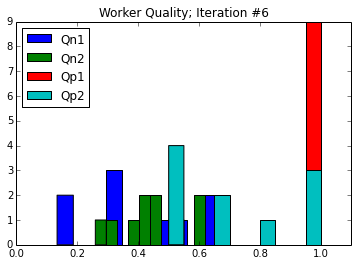

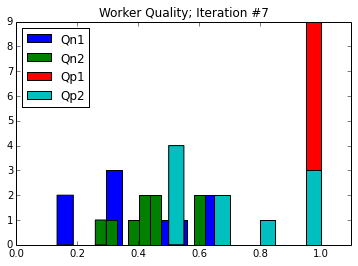

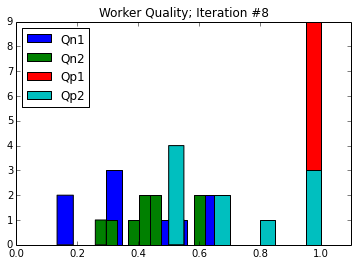

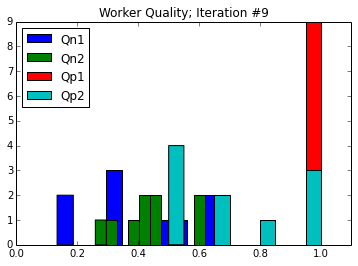

In [78]:
run_all_experiment_plots(3,19,1)

# A_thres = median(Tinit tks)

In [97]:
DATA_DIR="output_15"
exp_num=20
print "Running experiment #",exp_num
objid=3
end = time.time()
Tstar_idx_lst ,likelihood_lst,Qj_lst,Tstar_lst=runTileAdjacentMLConstruction(objid,workerErrorfunc="GTLSA",Qjfunc=QjGTLSA,A_percentile=-1,Niter=10,DEBUG=True,PLOT_LIKELIHOOD=False)
pkl.dump(likelihood_lst,open("likelihood_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_lst,open("Tstar_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_idx_lst,open("Tstar_idx_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Qj_lst,open("Qj_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
end2 = time.time()
print "Time Elapsed: ",end2-end

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 91.449367088607588 359.46202531645565 at 91.449367088607588 359.46202531645565
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (65 413, 68.5 413.833) and LINESTRING (68.5 413.833, 56 408) at 68.499999999999986 413.83333333333331
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (76.6943 334.123, 70.8 330.4) and LINESTRING (70.8 330.4, 77.6902 334.752) at 73.034136727028169 331.8110337223336
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.

Running experiment # 20
Compute Core Tiles
Initialize Tiles
Estimate based on initial tileset and get good Qjs

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 66.1622 327.068) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (87.2817 344.577, 86.0132 340.047) and LINESTRING (86.3527 341.26, 87.0543 343.765) at 86.751444443346287 342.68373015480813
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (61.1538 324.308, 60.6667 324) and LINESTRING (60.6667 324, 60.6667 324) at 60.666666666666558 323.99999999999994
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.6667 324, 60.6667 324) and LINESTRING (59.9444 323.544, 60.6667 324) at 60.666666666666394 323.99999999999983
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (50 318.111, 51.8571 319.143) and LINESTRING (51.8571 319.143, 50 318.4) at 51.857142857142


Qj: 

  0%|          | 0/10 [00:00<?, ?it/s]

 [(0.6101694915254238, 0.5, 0.475, 0.0), (0.3644067796610169, 0.5, 0.775, 1.0), (0.3728813559322034, 1.0, 0.75, 0.0), (0.5508474576271186, 0.5, 0.825, 1.0), (0.4491525423728814, 1.0, 0.675, 1.0), (0.6101694915254238, 0.5, 0.825, 0.5), (0.4491525423728814, 0.5, 0.7, 1.0), (0.6864406779661016, 1.0, 0.625, 0.5), (0.3220338983050847, 0.0, 0.925, 1.0), (0.4830508474576271, 1.0, 0.775, 0.5)]
Iteration # 0
ML construction of Tstar
Add core tiles to first occurence of tk satisfying criterion
Excluding set([68])
d'=0; good_dPrime_tcount=1

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 91.449367088607588 359.46202531645565



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (86.1342 340.479, 86.3495 341.248) and LINESTRING (86.0132 340.047, 86.8487 343.031) at 86.159305132533717 340.56894690190609


 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 57.2973 322.165) at 60.857142857142833 324.14285714285711


 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk 70
Adding tk 71
Adding tk 78
Adding tk 156
Adding tk 85
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.2727 338.909) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.27272727272539 338.90909090908974


 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=52

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 56.8652 321.925) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 130
Adding tk 4
Adding tk 135
Adding tk 8
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 12
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 42
Adding tk 44
Adding tk 46
Adding tk 47
Adding tk 50
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.3333 338.056, 84.6667 338.444) and LINESTRING (82.7143 337.143, 85 338.667) at 84.666666666666629 338.4444444444444


 55
Adding tk 56
Adding tk 138
Adding tk 62
Adding tk 64
Adding tk 72
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 85 338.667) and LINESTRING (84.7615 338.448, 85 338.667) at 84.999999999999957 338.66666666666663


 76
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 84
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=48
Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 52
Adding tk 53
Adding tk 58
Adding tk 61
Adding tk 74
Adding tk

 10%|█         | 1/10 [00:05<00:46,  0.19it/s]

 79
Adding tk 103
Adding tk 123
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=12
Number of tks in shell:  0
Current shell index: []
Iteration # 1
E-step : Estimate Qj parameters
Qj:  [(0.5923566878980892, 0.75, 1.0, -1), (0.33121019108280253, 0.25, 1.0, -1), (0.34394904458598724, 1.0, 1.0, -1), (0.458598

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 60.6667 324) and LINESTRING (60.8571 324.143, 60.6667 324) at 60.6666666666666 323.99999999999994



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 0
Adding tk 4
Adding tk 135
Adding tk 8
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 12
Adding tk 13
Adding tk 142
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 22
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.6667 324, 60.6657 323.999) and LINESTRING (60.6657 323.999, 60.8571 324.143) at 60.665965096022852 323.99947382201714


 34
Adding tk 39
Adding tk 7
Adding tk 44
Adding tk 46
Adding tk 47
Adding tk 50
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.7143 337.143, 84.6667 338.444) and LINESTRING (82.7143 337.143, 85 338.667) at 82.714285714285523 337.142857142857


 56
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 85 338.667) and LINESTRING (84.7615 338.448, 85 338.667) at 84.999999999999957 338.66666666666663


 138
Adding tk 62
Adding tk 66
Adding tk 67
Adding tk 72
Adding tk 76
Adding tk 77
Adding tk 80
Adding tk 81
Adding tk 83
Adding tk 9
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=45
Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104

 20%|██        | 2/10 [00:10<00:42,  0.19it/s]

 61
Adding tk 65
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=14
Number of tks in shell:  0
Current shell index: []
Iteration #

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 330.405, 70.8 330.4) at 70.800000000000736 330.4

 2
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 0.5897435897435898, 0.0), (0.4957983193277311, 0.3333333333333333, 0.6666666666666666, 1.0), (0.4369747899159664, 0.6666666666666666, 0.6410256410256411, 1.0), (0.5378151260504201, 0.6666666666666666, 0.6153846153846154, 1.0), (0.4117647058823529, 0.3333333333333333, 0.5897435897435898, 1.0), (0.6134453781512605, 0.6666666666666666, 0.41025641025641024, 0.0), (0.2689075630252101, 0.0, 0.7692307692307693, 1.0), (0.42857142857142855, 1.0, 0.6153846153846154, 1.0)]
ML construction of Tstar
Add core tiles to first occurence of tk satisfying criterion
Excluding set([68])
d'=0; good_dPrime_tcount=1

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 30%|███       | 3/10 [00:56<02:12,  0.05it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 3
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 40%|████      | 4/10 [01:41<02:32,  0.04it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 4
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 50%|█████     | 5/10 [02:27<02:27,  0.03it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 5
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 60%|██████    | 6/10 [03:12<02:08,  0.03it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 6
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 70%|███████   | 7/10 [03:57<01:41,  0.03it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 7
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 80%|████████  | 8/10 [04:43<01:10,  0.03it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 8
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 90%|█████████ | 9/10 [05:30<00:36,  0.03it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 9
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Time Elapsed:  397.646336079


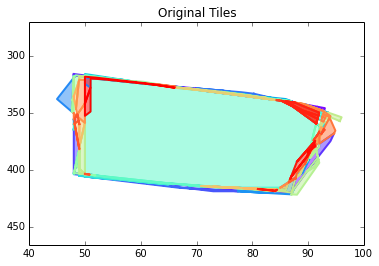

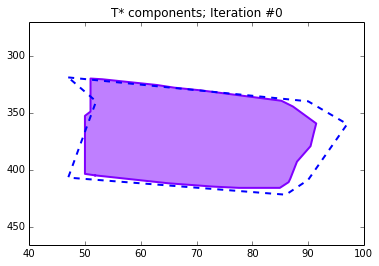

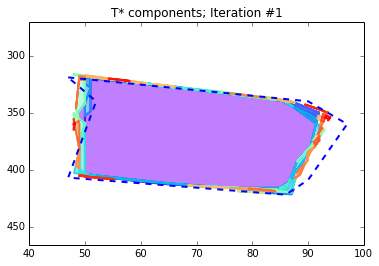

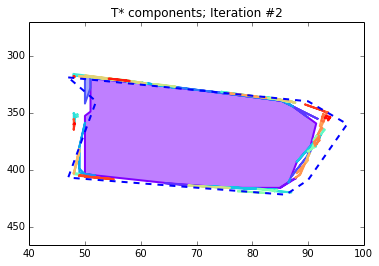

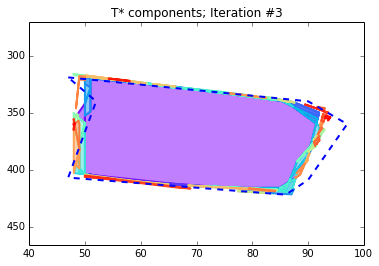

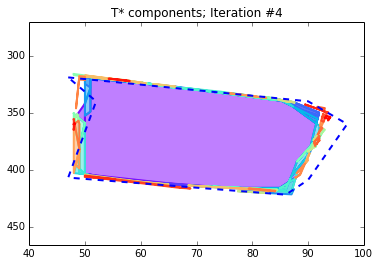

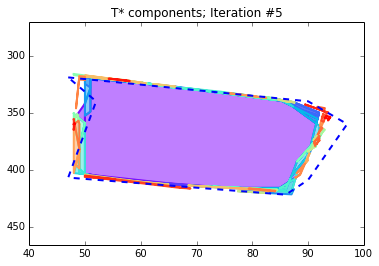

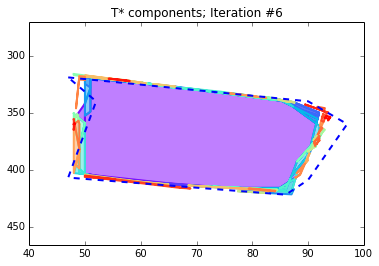

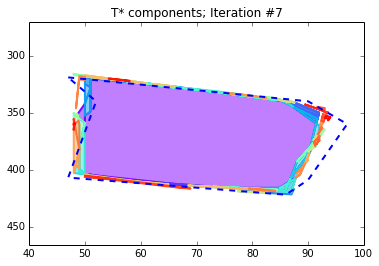

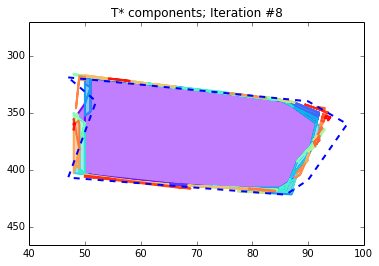

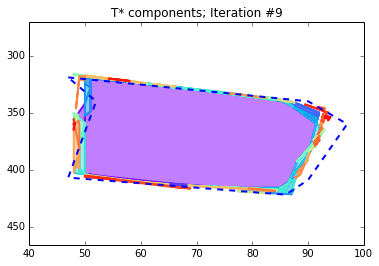

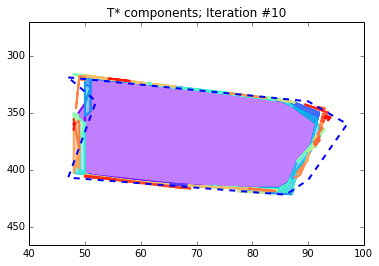

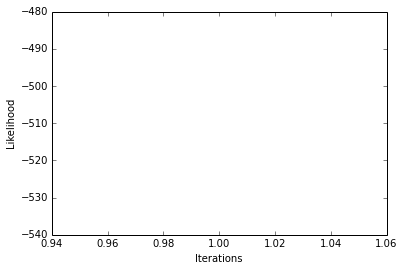

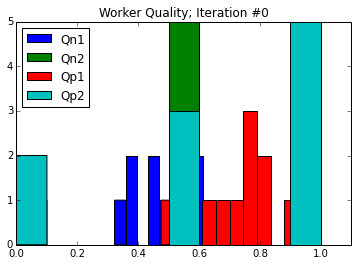

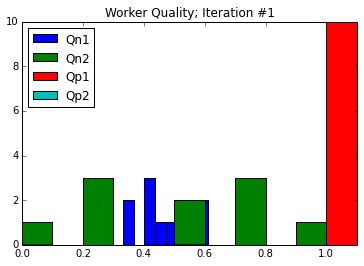

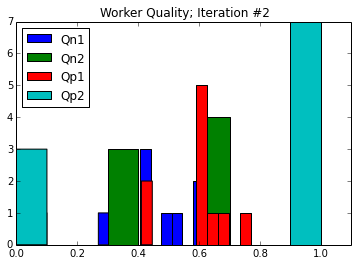

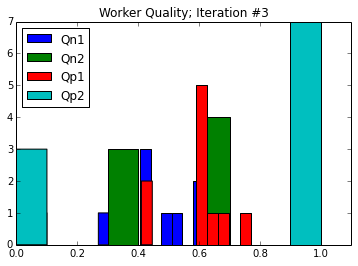

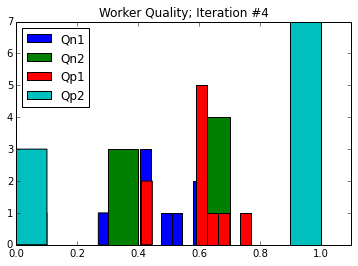

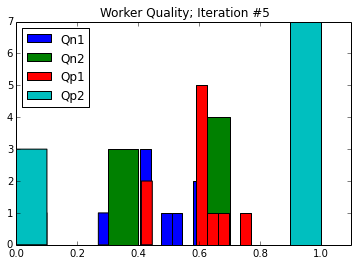

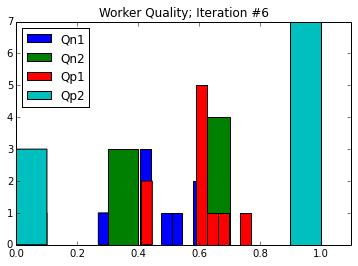

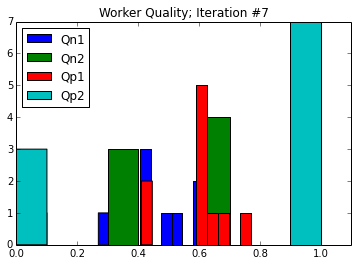

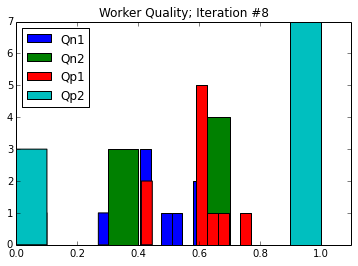

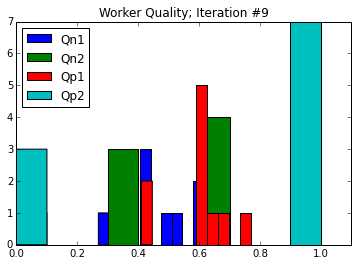

In [98]:
run_all_experiment_plots(3,20,1)

# A_thres = mean(Tinit tks)

In [99]:
DATA_DIR="output_15"
exp_num=21
print "Running experiment #",exp_num
objid=3
end = time.time()
Tstar_idx_lst ,likelihood_lst,Qj_lst,Tstar_lst=runTileAdjacentMLConstruction(objid,workerErrorfunc="GTLSA",Qjfunc=QjGTLSA,A_percentile=-1,Niter=10,DEBUG=True,PLOT_LIKELIHOOD=False)
pkl.dump(likelihood_lst,open("likelihood_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_lst,open("Tstar_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_idx_lst,open("Tstar_idx_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Qj_lst,open("Qj_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
end2 = time.time()
print "Time Elapsed: ",end2-end

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 91.449367088607588 359.46202531645565 at 91.449367088607588 359.46202531645565
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (65 413, 68.5 413.833) and LINESTRING (68.5 413.833, 56 408) at 68.499999999999986 413.83333333333331
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (76.6943 334.123, 70.8 330.4) and LINESTRING (70.8 330.4, 77.6902 334.752) at 73.034136727028169 331.8110337223336
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.

Running experiment # 21
Compute Core Tiles
Initialize Tiles
Estimate based on initial tileset and get good Qjs

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 66.1622 327.068) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (87.2817 344.577, 86.0132 340.047) and LINESTRING (86.3527 341.26, 87.0543 343.765) at 86.751444443346287 342.68373015480813
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (61.1538 324.308, 60.6667 324) and LINESTRING (60.6667 324, 60.6667 324) at 60.666666666666558 323.99999999999994
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.6667 324, 60.6667 324) and LINESTRING (59.9444 323.544, 60.6667 324) at 60.666666666666394 323.99999999999983
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (50 318.111, 51.8571 319.143) and LINESTRING (51.8571 319.143, 50 318.4) at 51.857142857142


Qj: 

  0%|          | 0/10 [00:00<?, ?it/s]

 [(0.6101694915254238, 0.5, 0.475, 0.0), (0.3644067796610169, 0.5, 0.775, 1.0), (0.3728813559322034, 1.0, 0.75, 0.0), (0.5508474576271186, 0.5, 0.825, 1.0), (0.4491525423728814, 1.0, 0.675, 1.0), (0.6101694915254238, 0.5, 0.825, 0.5), (0.4491525423728814, 0.5, 0.7, 1.0), (0.6864406779661016, 1.0, 0.625, 0.5), (0.3220338983050847, 0.0, 0.925, 1.0), (0.4830508474576271, 1.0, 0.775, 0.5)]
Iteration # 0
ML construction of Tstar
Add core tiles to first occurence of tk satisfying criterion
Excluding set([68])
d'=0; good_dPrime_tcount=1

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 91.449367088607588 359.46202531645565



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (86.1342 340.479, 86.3495 341.248) and LINESTRING (86.0132 340.047, 86.8487 343.031) at 86.159305132533717 340.56894690190609


 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 57.2973 322.165) at 60.857142857142833 324.14285714285711


 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk 70
Adding tk 71
Adding tk 78
Adding tk 156
Adding tk 85
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.2727 338.909) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.27272727272539 338.90909090908974


 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=52

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 56.8652 321.925) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 130
Adding tk 4
Adding tk 135
Adding tk 8
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 12
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 42
Adding tk 44
Adding tk 46
Adding tk 47
Adding tk 50
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.3333 338.056, 84.6667 338.444) and LINESTRING (82.7143 337.143, 85 338.667) at 84.666666666666629 338.4444444444444


 56
Adding tk 138
Adding tk 62
Adding tk 64
Adding tk 72
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 85 338.667) and LINESTRING (84.7615 338.448, 85 338.667) at 84.999999999999957 338.66666666666663


 76
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 84
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=48
Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 52
Adding tk 53
Adding tk 58
Adding tk 61
Adding tk 74
Adding tk

 10%|█         | 1/10 [00:05<00:48,  0.19it/s]

 79
Adding tk 103
Adding tk 123
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=12
Number of tks in shell:  0
Current shell index: []
Iteration # 1
E-step : Estimate Qj parameters
Qj:  [(0.5923566878980892, 0.75, 1.0, -1), (0.33121019108280253, 0.25, 1.0, -1), (0.34394904458598724, 1.0, 1.0, -1), (0.458598

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 60.6667 324) and LINESTRING (60.8571 324.143, 60.6667 324) at 60.6666666666666 323.99999999999994



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 0
Adding tk 4
Adding tk 135
Adding tk 8
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 12
Adding tk 13
Adding tk 142
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 22
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.6667 324, 60.6657 323.999) and LINESTRING (60.6657 323.999, 60.8571 324.143) at 60.665965096022852 323.99947382201714


 39
Adding tk 7
Adding tk 44
Adding tk 46
Adding tk 47
Adding tk 50
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.7143 337.143, 84.6667 338.444) and LINESTRING (82.7143 337.143, 85 338.667) at 82.714285714285523 337.142857142857


 56
Adding tk 138
Adding tk 62
Adding tk 66
Adding tk 67
Adding tk 72
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 85 338.667) and LINESTRING (84.7615 338.448, 85 338.667) at 84.999999999999957 338.66666666666663


 76
Adding tk 77
Adding tk 80
Adding tk 81
Adding tk 83
Adding tk 9
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=45
Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 132
Adding tk 134
Adding tk 30
Adding tk 36


 20%|██        | 2/10 [00:11<00:44,  0.18it/s]

 58
Adding tk 61
Adding tk 65
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=14
Number of tks in shell:  0
Current shell index: []
Iteration #

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 330.405, 70.8 330.4) at 70.800000000000736 330.4

 2
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 0.5897435897435898, 0.0), (0.4957983193277311, 0.3333333333333333, 0.6666666666666666, 1.0), (0.4369747899159664, 0.6666666666666666, 0.6410256410256411, 1.0), (0.5378151260504201, 0.6666666666666666, 0.6153846153846154, 1.0), (0.4117647058823529, 0.3333333333333333, 0.5897435897435898, 1.0), (0.6134453781512605, 0.6666666666666666, 0.41025641025641024, 0.0), (0.2689075630252101, 0.0, 0.7692307692307693, 1.0), (0.42857142857142855, 1.0, 0.6153846153846154, 1.0)]
ML construction of Tstar
Add core tiles to first occurence of tk satisfying criterion
Excluding set([68])
d'=0; good_dPrime_tcount=1

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 69
Adding tk 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 30%|███       | 3/10 [00:59<02:19,  0.05it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 3
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 40%|████      | 4/10 [01:46<02:40,  0.04it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 4
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 50%|█████     | 5/10 [02:33<02:33,  0.03it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 5
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 60%|██████    | 6/10 [03:20<02:13,  0.03it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 6
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 70%|███████   | 7/10 [04:06<01:45,  0.03it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 7
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk 115
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 80%|████████  | 8/10 [04:52<01:13,  0.03it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 8
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 111
Adding tk 112
Adding tk 113
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 114
Adding tk 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 90%|█████████ | 9/10 [38:06<04:14,  0.00it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 33

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 9
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 69
Adding tk 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Time Elapsed:  2356.46473312


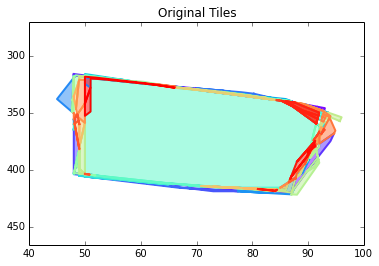

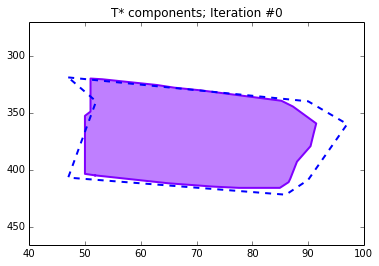

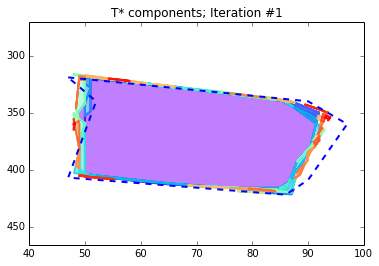

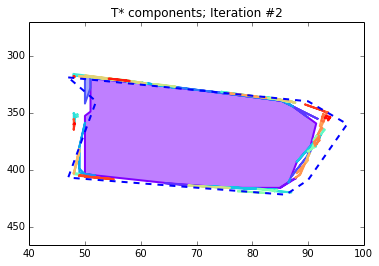

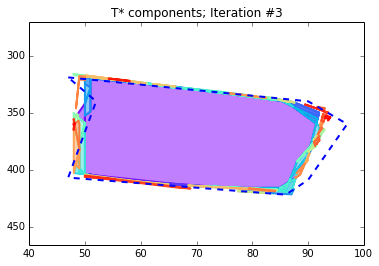

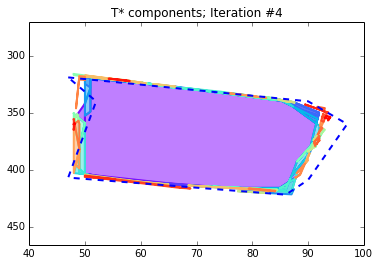

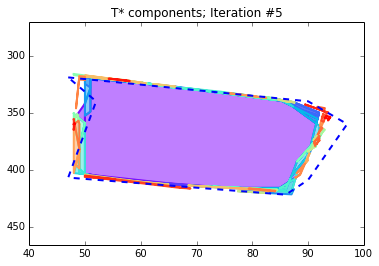

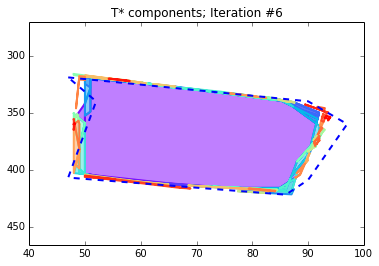

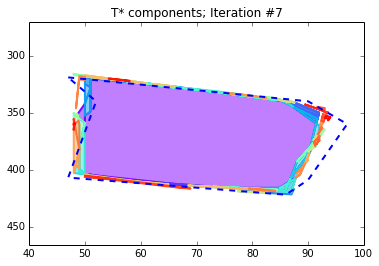

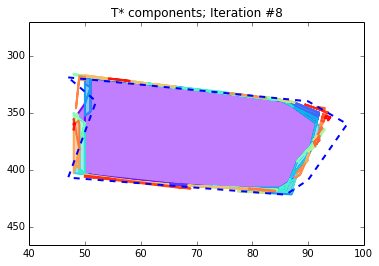

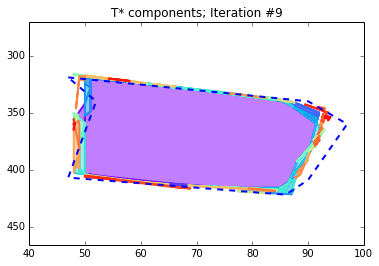

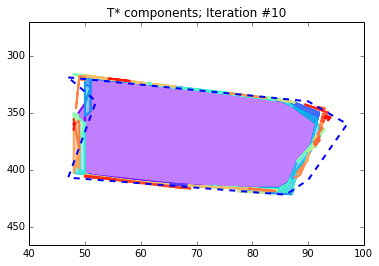

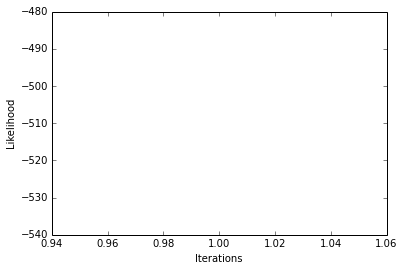

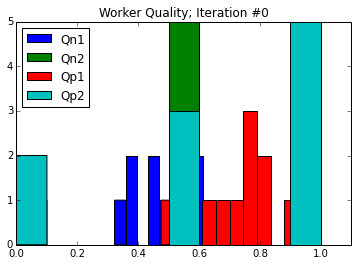

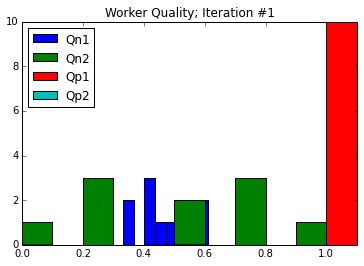

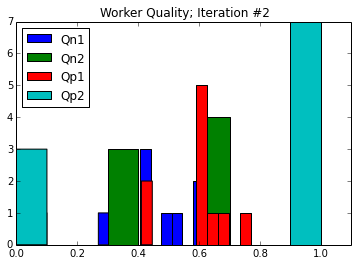

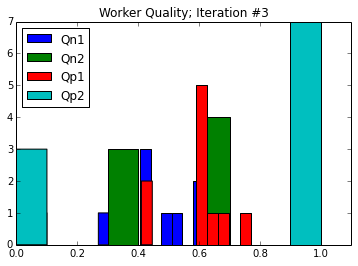

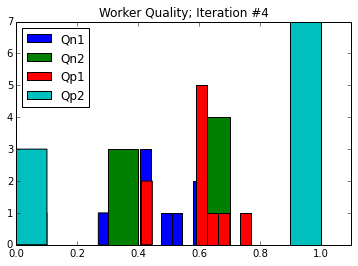

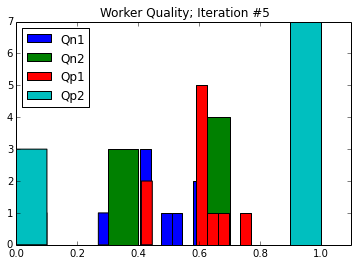

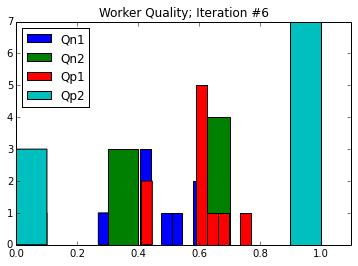

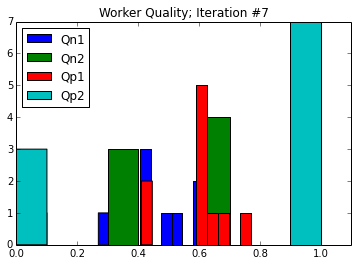

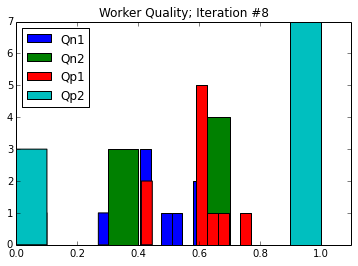

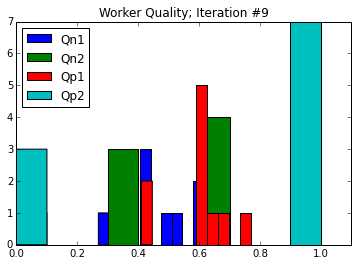

In [100]:
run_all_experiment_plots(3,21,1)

- ~~fix likelihood code bug, add pInT and pNotInT separately~~
- Qj list : 
    - plt.hist(Qjs[i],bins=len(Qj),label="Q{}".format(i))
    - need to plot same number of Qjs 
    - Qj not getting updated because Qj for all workers but we are running on sampled tiles 
    

In [111]:
DATA_DIR="output_15"
exp_num=23
print "Running experiment #",exp_num
objid=3
end = time.time()
Tstar_idx_lst ,likelihood_lst,Qj_lst,Tstar_lst,pInT,pNotInT=runTileAdjacentMLConstruction(objid,workerErrorfunc="GTLSA",Qjfunc=QjGTLSA,A_percentile=-1,Niter=5,DEBUG=True,PLOT_LIKELIHOOD=False)
pkl.dump(likelihood_lst,open("likelihood_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_lst,open("Tstar_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_idx_lst,open("Tstar_idx_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Qj_lst,open("Qj_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
end2 = time.time()
print "Time Elapsed: ",end2-end

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 91.449367088607588 359.46202531645565 at 91.449367088607588 359.46202531645565
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (65 413, 68.5 413.833) and LINESTRING (68.5 413.833, 56 408) at 68.499999999999986 413.83333333333331
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (76.6943 334.123, 70.8 330.4) and LINESTRING (70.8 330.4, 77.6902 334.752) at 73.034136727028169 331.8110337223336
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.

Running experiment # 23
Compute Core Tiles
Initialize Tiles
Estimate based on initial tileset and get good Qjs

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 66.1622 327.068) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (87.2817 344.577, 86.0132 340.047) and LINESTRING (86.3527 341.26, 87.0543 343.765) at 86.751444443346287 342.68373015480813
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (61.1538 324.308, 60.6667 324) and LINESTRING (60.6667 324, 60.6667 324) at 60.666666666666558 323.99999999999994
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.6667 324, 60.6667 324) and LINESTRING (59.9444 323.544, 60.6667 324) at 60.666666666666394 323.99999999999983
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (50 318.111, 51.8571 319.143) and LINESTRING (51.8571 319.143, 50 318.4) at 51.857142857142


Qj: 

  0%|          | 0/5 [00:00<?, ?it/s]

 [(0.6101694915254238, 0.5, 0.475, 0.0), (0.3644067796610169, 0.5, 0.775, 1.0), (0.3728813559322034, 1.0, 0.75, 0.0), (0.5508474576271186, 0.5, 0.825, 1.0), (0.4491525423728814, 1.0, 0.675, 1.0), (0.6101694915254238, 0.5, 0.825, 0.5), (0.4491525423728814, 0.5, 0.7, 1.0), (0.6864406779661016, 1.0, 0.625, 0.5), (0.3220338983050847, 0.0, 0.925, 1.0), (0.4830508474576271, 1.0, 0.775, 0.5)]
Iteration # 0
ML construction of Tstar
Add core tiles to first occurence of tk satisfying criterion
Excluding set([68])
d'=0; good_dPrime_tcount=1

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 91.449367088607588 359.46202531645565



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (86.1342 340.479, 86.3495 341.248) and LINESTRING (86.0132 340.047, 86.8487 343.031) at 86.159305132533717 340.56894690190609


 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 57.2973 322.165) at 60.857142857142833 324.14285714285711


 49
Adding tk 147
Adding tk 69
Adding tk 70
Adding tk 71
Adding tk 78
Adding tk 156
Adding tk 85
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.2727 338.909) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.27272727272539 338.90909090908974


 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=52

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 56.8652 321.925) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 130
Adding tk 4
Adding tk 135
Adding tk 8
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 12
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 42
Adding tk 44
Adding tk 46
Adding tk 47
Adding tk 50
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.3333 338.056, 84.6667 338.444) and LINESTRING (82.7143 337.143, 85 338.667) at 84.666666666666629 338.4444444444444


 56
Adding tk 138
Adding tk 62
Adding tk 64
Adding tk 72
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 85 338.667) and LINESTRING (84.7615 338.448, 85 338.667) at 84.999999999999957 338.66666666666663


 76
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 84
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=48
Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 52
Adding tk 53
Adding tk 58
Adding tk 61
Adding tk 74
Adding tk

 20%|██        | 1/5 [00:04<00:19,  0.20it/s]

 79
Adding tk 103
Adding tk 123
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=12
Number of tks in shell:  0
Current shell index: []
Iteration # 1
E-step : Estimate Qj parameters
Qj:  [(0.5923566878980892, 0.75, 1.0, -1), (0.33121019108280253, 0.25, 1.0, -1), (0.34394904458598724, 1.0, 1.0, -1), (0.458598

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 60.6667 324) and LINESTRING (60.8571 324.143, 60.6667 324) at 60.6666666666666 323.99999999999994



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 0
Adding tk 4
Adding tk 135
Adding tk 8
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 12
Adding tk 13
Adding tk 142
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 22
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.6667 324, 60.6657 323.999) and LINESTRING (60.6657 323.999, 60.8571 324.143) at 60.665965096022852 323.99947382201714


 34
Adding tk 39
Adding tk 7
Adding tk 44
Adding tk 46
Adding tk 47
Adding tk 50
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.7143 337.143, 84.6667 338.444) and LINESTRING (82.7143 337.143, 85 338.667) at 82.714285714285523 337.142857142857


 56
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 85 338.667) and LINESTRING (84.7615 338.448, 85 338.667) at 84.999999999999957 338.66666666666663


 138
Adding tk 62
Adding tk 66
Adding tk 67
Adding tk 72
Adding tk 76
Adding tk 77
Adding tk 80
Adding tk 81
Adding tk 83
Adding tk 9
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=45
Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104

 40%|████      | 2/5 [00:10<00:15,  0.20it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 330

 65
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=14
Number of tks in shell:  0
Current shell index: []
Iteration # 2
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 111
Adding tk 112
Adding tk 113
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 114
Adding tk 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 60%|██████    | 3/5 [00:57<00:38,  0.05it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 330

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 3
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41
Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65,

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722


 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 80%|████████  | 4/5 [01:45<00:26,  0.04it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 330

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Iteration # 4
E-step : Estimate Qj parameters
Qj:  [(0.5966386554621849, 0.6666666666666666, 0.4358974358974359, 0.0), (0.31092436974789917, 0.3333333333333333, 0.6153846153846154, 1.0), (0.31932773109243695, 1.0, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (61.1538 324.308, 60.8571 324.143) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 44
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142783 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 72
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=41

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 2
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 58
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 61
Adding tk 74
Adding tk 79
Adding tk 103
Adding tk 123
Excluding

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=13
Number of tks in shell:  0
Current shell index: []
Time Elapsed:  173.36728096


In [112]:
# run_all_experiment_plots(3,23,1)

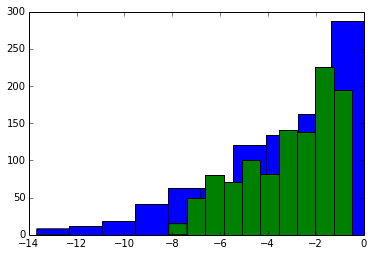

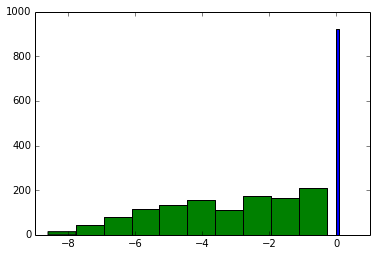

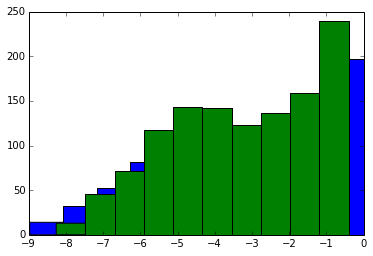

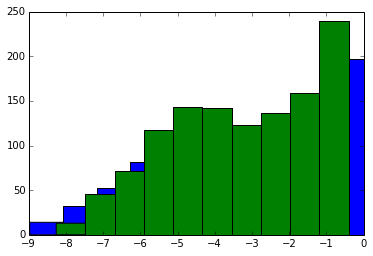

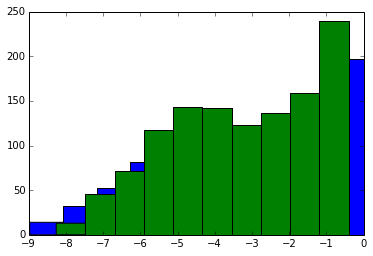

In [124]:
for i in range(len(pInT)):
    plt.figure()
    pInTi = np.array(pInT[i])
    pNotInTi = np.array(pNotInT[i])
    plt.hist(pInTi[pInTi > -1E308] )
    plt.hist(pNotInTi[pNotInTi > -1E308] )

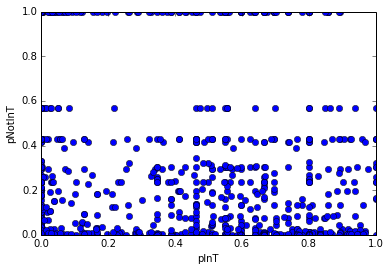

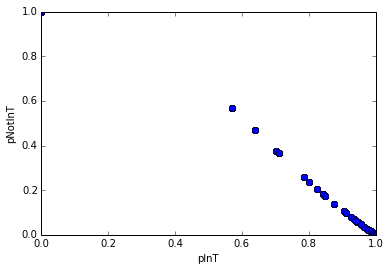

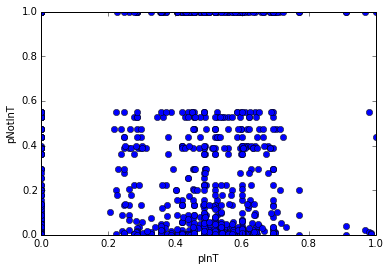

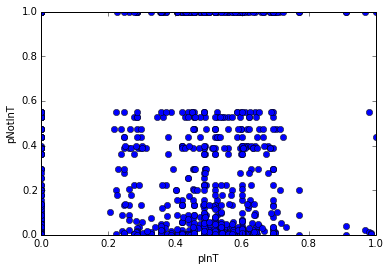

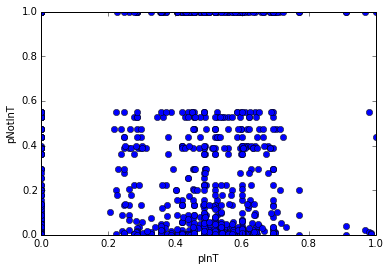

In [150]:
for i in range(len(pInT)):
    plt.figure()
    pInTi = e**np.array(pInT[i])
    pNotInTi = e**np.array(pNotInT[i])
    fpInTi = np.array(pInTi)#[pInTi > -1E308]
    fpNotInTi= np.array(pNotInTi)#[pNotInTi > -1E308] 
    fpInTi = fpInTi/(fpInTi+fpNotInTi)
    fpNotInTi = fpNotInTi/(fpInTi+fpNotInTi)
    fpInTi=fpInTi[~np.isnan(fpInTi)]
    fpNotInTi=fpNotInTi[~np.isnan(fpInTi)]
    plt.plot(fpInTi,fpNotInTi,'o')
    plt.xlabel("pInT")
    plt.ylabel("pNotInT")

In [153]:
DATA_DIR="output_15"
exp_num=24
print "Running experiment #",exp_num
objid=3
end = time.time()
Tstar_idx_lst ,likelihood_lst,Qj_lst,Tstar_lst,pInT,pNotInT=runTileAdjacentMLConstruction(objid,workerErrorfunc="GTLSA",Qjfunc=QjGTLSA,A_percentile=-1,Niter=5,DEBUG=True,PLOT_LIKELIHOOD=False)
pkl.dump(likelihood_lst,open("likelihood_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_lst,open("Tstar_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_idx_lst,open("Tstar_idx_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Qj_lst,open("Qj_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
end2 = time.time()
print "Time Elapsed: ",end2-end

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 91.449367088607588 359.46202531645565 at 91.449367088607588 359.46202531645565
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (65 413, 68.5 413.833) and LINESTRING (68.5 413.833, 56 408) at 68.499999999999986 413.83333333333331
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (76.6943 334.123, 70.8 330.4) and LINESTRING (70.8 330.4, 77.6902 334.752) at 73.034136727028169 331.8110337223336
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.

Running experiment # 24
Compute Core Tiles
Initialize Tiles
Estimate based on initial tileset and get good Qjs

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 66.1622 327.068) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (87.2817 344.577, 86.0132 340.047) and LINESTRING (86.3527 341.26, 87.0543 343.765) at 86.751444443346287 342.68373015480813
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (61.1538 324.308, 60.6667 324) and LINESTRING (60.6667 324, 60.6667 324) at 60.666666666666558 323.99999999999994
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.6667 324, 60.6667 324) and LINESTRING (59.9444 323.544, 60.6667 324) at 60.666666666666394 323.99999999999983
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (50 318.111, 51.8571 319.143) and LINESTRING (51.8571 319.143, 50 318.4) at 51.857142857142


Qj: 

  0%|          | 0/5 [00:00<?, ?it/s]

 [(0.6101694915254238, 0.5, 0.475, 0.0), (0.3644067796610169, 0.5, 0.775, 1.0), (0.3728813559322034, 1.0, 0.75, 0.0), (0.5508474576271186, 0.5, 0.825, 1.0), (0.4491525423728814, 1.0, 0.675, 1.0), (0.6101694915254238, 0.5, 0.825, 0.5), (0.4491525423728814, 0.5, 0.7, 1.0), (0.6864406779661016, 1.0, 0.625, 0.5), (0.3220338983050847, 0.0, 0.925, 1.0), (0.4830508474576271, 1.0, 0.775, 0.5)]
Iteration # 0
ML construction of Tstar
Add core tiles to first occurence of tk satisfying criterion
Excluding set([68])
d'=0; good_dPrime_tcount=1

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 91.449367088607588 359.46202531645565



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (86.1342 340.479, 86.3495 341.248) and LINESTRING (86.0132 340.047, 86.8487 343.031) at 86.159305132533717 340.56894690190609


 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (66 328, 60.8571 324.143) and LINESTRING (60.8571 324.143, 57.2973 322.165) at 60.857142857142833 324.14285714285711


 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk 70
Adding tk 71
Adding tk 78
Adding tk 156
Adding tk 85
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.2727 338.909) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.27272727272539 338.90909090908974


102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=52

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 56.8652 321.925) at 60.857142857142826 324.14285714285711



Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 130
Adding tk 4
Adding tk 135
Adding tk 8
Adding tk 137
Adding tk 10
Adding tk 139
Adding tk 12
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 39
Adding tk 42
Adding tk 44
Adding tk 46
Adding tk 47
Adding tk 50
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.3333 338.056, 84.6667 338.444) and LINESTRING (82.7143 337.143, 85 338.667) at 84.666666666666629 338.4444444444444


 56
Adding tk 138
Adding tk 62
Adding tk 64
Adding tk 72
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 85 338.667) and LINESTRING (84.7615 338.448, 85 338.667) at 84.999999999999957 338.66666666666663


 76
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 84
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=48
Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.5228 320.209, 55.6667 320.667) and LINESTRING (55.6667 320.667, 54.2439 320.098) at 55.283182842531858 320.51327313701273


 52
Adding tk 53
Adding tk 58
Adding tk 61
Adding tk 74
Adding tk

 20%|██        | 1/5 [00:04<00:19,  0.20it/s]

 79
Adding tk 103
Adding tk 123
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=12
Number of tks in shell:  0
Current shell index: []
Iteration # 1
E-step : Estimate Qj parameters
Median Area Threshold: 1.05625
Qj:  [(0.5974842767295597, 0.5, 1.0, -1), (0.3270440251572327, 0.5, 1.0, -1), (0.352201257861635

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 60.6667 324) and LINESTRING (60.6667 324, 60.6667 324) at 60.666666666666522 323.99999999999989


 23
Adding tk 155
Adding tk 32
Adding tk 34
Adding tk 7
Adding tk 44
Adding tk 46
Adding tk 47
Adding tk 50
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.7143 337.143, 84.6667 338.444) and LINESTRING (82.7143 337.143, 85 338.667) at 82.714285714285523 337.142857142857


 56
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 85 338.667) and LINESTRING (84.7615 338.448, 85 338.667) at 84.999999999999957 338.66666666666663


 138
Adding tk 66
Adding tk 67
Adding tk 72
Adding tk 76
Adding tk 77
Adding tk 81
Adding tk 83
Adding tk 9
Adding tk 105
Adding tk 108
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=37
Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 30
Adding tk 36
Ad

 40%|████      | 2/5 [00:09<00:14,  0.20it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 330

 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=11
Number of tks in shell:  0
Current shell index: []
Iteration # 2
E-step : Estimate Qj parameters
Median Area Threshold: 0.264546059271
Qj:  [(0.5983606557377049, -1, 0.4358974358974359, 0.0), (0.3114754098360656, -1, 0.6153846153846154, 1.0), (0.3360655737704918, -

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 102
Adding tk 106
Adding tk 111
Adding tk 112
Adding tk 114
Adding tk 116
Adding tk 117
Adding tk 120
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=37
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 8
Adding tk 142
Adding tk 143
Adding tk 34
Adding tk 44
Adding tk 46
Adding tk 60
Adding tk 80
Adding tk 81
Adding tk 82
Adding tk 14
Adding tk 89
Adding tk 95
Adding tk 105
Adding tk 109
Ad

 60%|██████    | 3/5 [00:53<00:35,  0.06it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 330

 53
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=4
Number of tks in shell:  0
Current shell index: []
Iteration # 3
E-step : Estimate Qj parameters
Median Area Threshold: 3.125070791
Qj:  [(0.6016949152542372, 0.5, 0.42105263157894735, 0.5), (0.3050847457627119, 0.5, 0.631578947368421, 0.5), (0.32203389

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228


 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 41
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk 78
Adding tk 156
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 102
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (61.7789 324.759, 61.6129 324.71) and LINESTRING (61.6129 324.71, 61.6129 324.71) at 61.612903226309299 324.70967741960698


 106
Adding tk 112
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=42
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 4
Adding tk 135
Adding tk 137
Adding tk 139
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 145
Adding tk 146
Adding tk 23
Adding tk 155
Adding tk 5
Adding tk 159
Adding tk 32
Adding tk 34
Adding tk 38
Adding tk 39
Adding tk 44
Adding tk 46


 80%|████████  | 4/5 [01:36<00:24,  0.04it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.857142857142826 324.14285714285711
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.8 330.4, 70.8 330.4) and LINESTRING (70.808 330


Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 37
Adding tk 61
Adding tk 79
Adding tk 103
Adding tk 104
Adding tk 123
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.6333 351.567, 48.6333 351.567) and LINESTRING (48.6333 351.567, 48.6333 351.567) at 48.633333333430279 351.56666666664228



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (73.8137 332.303, 73.6587 332.205) and LINESTRING (73.2513 331.948, 81.8059 337.351) at 73.678594329671895 332.21805957663491


 144
Adding tk 17
Adding tk 19
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk 152
Adding tk 25
Adding tk 154
Adding tk 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (56.2174 321.565, 60.8571 324.143) at 60.857142857142762 324.14285714285711


 71
Adding tk 78
Adding tk 156
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.75 331.375, 84.2727 338.909) and LINESTRING (84.2727 338.909, 72.75 331.375) at 73.830255681818059 332.08132102272725


 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (92.3878 368.429, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.457985035532076 373.63528380102042


 115
Adding tk 116
Adding tk 117
Adding tk 120
Adding tk 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=50
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 0
Adding tk 4
Adding tk 135
Adding tk 8
Adding tk 137
Adding tk 139
Adding tk 12
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk 20
Adding tk 22
Adding tk 23
Adding tk 155
Adding tk 159
Adding tk 32
A

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.5564 323.917) and LINESTRING (60.8571 324.143, 58.8571 322.643) at 60.775806466707145 324.08185485003037


 46
Adding tk 47
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.8571 324.143, 60.8571 324.143) and LINESTRING (60.8571 324.143, 60.8571 324.143) at 60.85714285714279 324.14285714285711


 60
Adding tk 138
Adding tk 62
Adding tk 66
Adding tk 67
Adding tk 72
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 85 338.667) and LINESTRING (84.7615 338.448, 85 338.667) at 84.999999999999957 338.66666666666663


 76
Adding tk 77
Adding tk 80
Adding tk 82
Adding tk 83
Adding tk 14
Adding tk 89
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=48

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48.1233 359.205, 48.1098 359.838) and LINESTRING (48.1137 359.824, 48.1098 359.838) at 48.109826589595379 359.83815028901722



Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Adding tk 132
Adding tk 134
Adding tk 21
Adding tk 30
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 52
Adding tk 53
Adding tk 58
Adding tk 61
Adding tk 65
Adding tk 74
Adding tk 79
Adding tk

 103
Adding tk 123
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=16
Number of tks in shell:  0
Current shell index: []
Time Elapsed:  162.748728991


In [159]:
my_BBG  = pd.read_csv("my_ground_truth.csv")
ground_truth_match = my_BBG[my_BBG.object_id==objid]
x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
BBG = shapely.geometry.Polygon(zip(x_locs,y_locs))

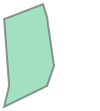

In [163]:
BBG

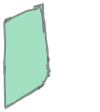

In [169]:
poly_recall(Tstar_lst[-1][0].buffer(-1e-10),BBG)

0.9143605795187035

In [167]:
poly_precision(Tstar_lst[-1][0].buffer(-1e-10),BBG)

0.9564465348406554

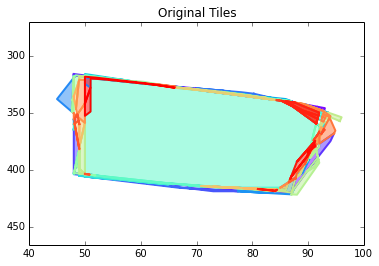

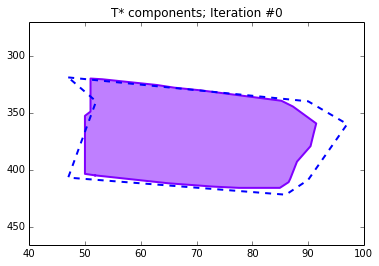

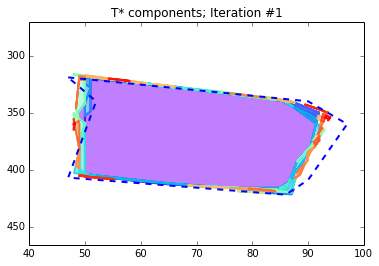

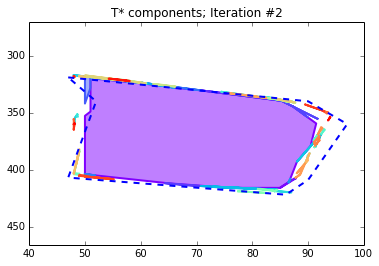

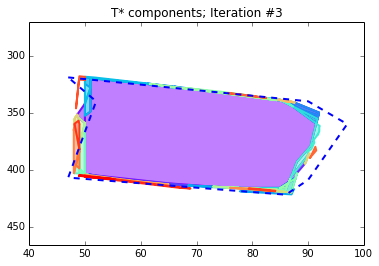

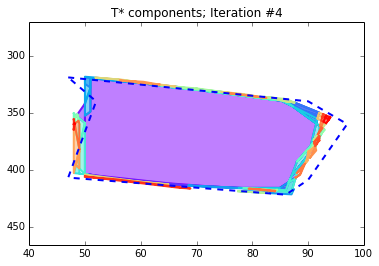

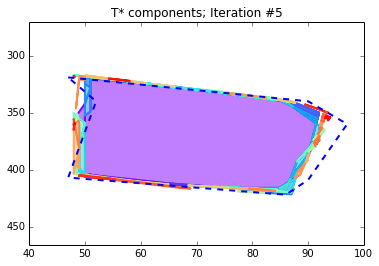

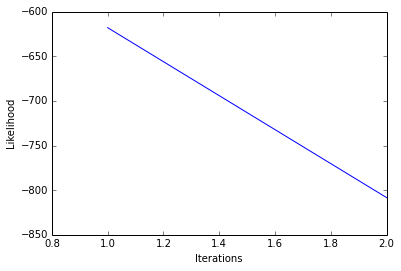

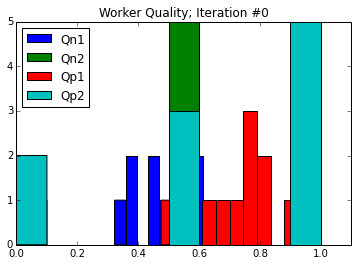

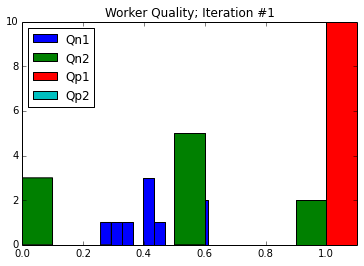

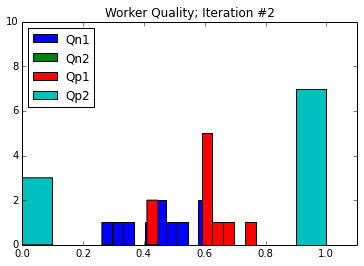

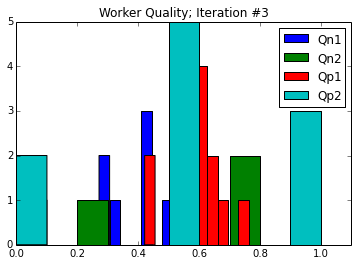

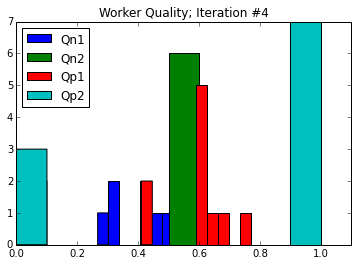

In [155]:
run_all_experiment_plots(3,24,1)

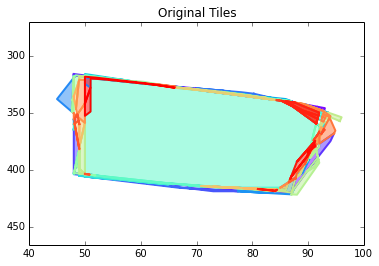

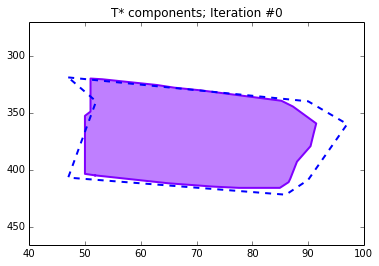

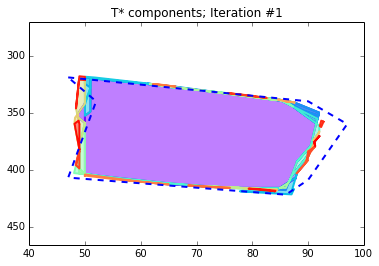

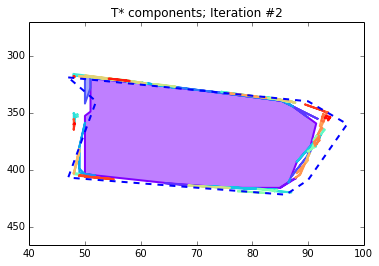

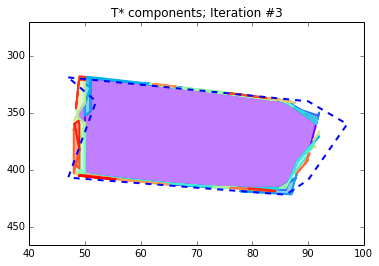

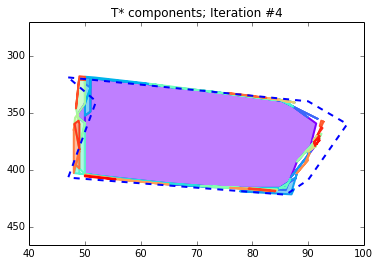

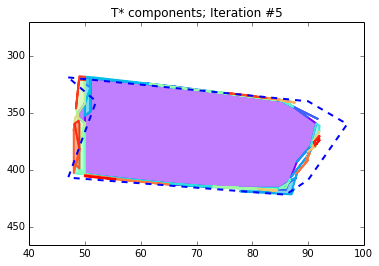

In [172]:
T_lst = pkl.load(open("output_15/Tstar_idx_obj3.pkl"))
Tstar_idx_lst = pkl.load(open("output_15/Tstar_idx_obj3.pkl"))
plot_Ts(objid,T_lst,Tstar_idx_lst,step_size=1)